# Pre-processing and clustering 3k PBMCs with scanpy

We document the pre-processing and clustering of 3000 PBMCs from a helathy data with the help of the scanpy package. The content is largely copied from https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html, though I have added my own comments to help new learners grasp a few technicalities that I struggled with.

In [2]:
## Data download. If you run the script for the first time, uncomment the three lines below by removing #
## Because the Jupyter notebook recognizes lines that start with ! as command-line commands
# !mkdir data
# !wget http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -O data/pbmc3k_filtered_gene_bc_matrices.tar.gz
# !cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz; rm !$

--2020-05-13 09:25:42--  http://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.224.102.50, 13.224.102.63, 13.224.102.80, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.224.102.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7621991 (7.3M) [application/x-tar]
Saving to: ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’

data/pbmc3k_filtere 100%[===================>]   7.27M  5.17MB/s    in 1.4s    

2020-05-13 09:25:44 (5.17 MB/s) - ‘data/pbmc3k_filtered_gene_bc_matrices.tar.gz’ saved [7621991/7621991]



**Note** In Jupyter notebooks and lab, you can see the documentation for a python function by hitting ``SHIFT + TAB`` after you enter the function. Hit it twice to expand the view.

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc

In [4]:
## verbosity setting: 0 for errors, 1 for warnings, 2 for info, and 3 for hitns
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=100)

scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.18.4 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.0 statsmodels==0.11.1 python-igraph==0.8.2


In [ ]:
results_file = './write/pbmc3k.h5ad' ## the file that will store the analysis results

In [5]:
## read in annotated data
adata = sc.read_10x_mtx(
    './data/filtered_gene_bc_matrices/hg19', # the directory with the '.mtx' file
    var_names='gene_symbols',                # use gene symbols as the variable names
    cache=True)                              # write a cache file for fastter subsequent reading

... writing an h5ad cache file to speedup reading next time


In [ ]:
adata.var_names_make_unique() # not necessary if `var_names='gene_ids'` is used in `sc.read_10x_mtx`

In [6]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738 
    var: 'gene_ids'

## Preprocessing

### Checking highly expressed genes

First we show genes that yield the highest fraction of counts in each single cell, across all cells.

The `sc.pl.highest_expr_genes` command normalizses counts per cell, and plots the genes that are most abundant in each cell. Note that MALAT1, a non-coding RNA that is known to be extremely abundant in many cells, ranks at the top.

normalizing counts per cell
    finished (0:00:00)


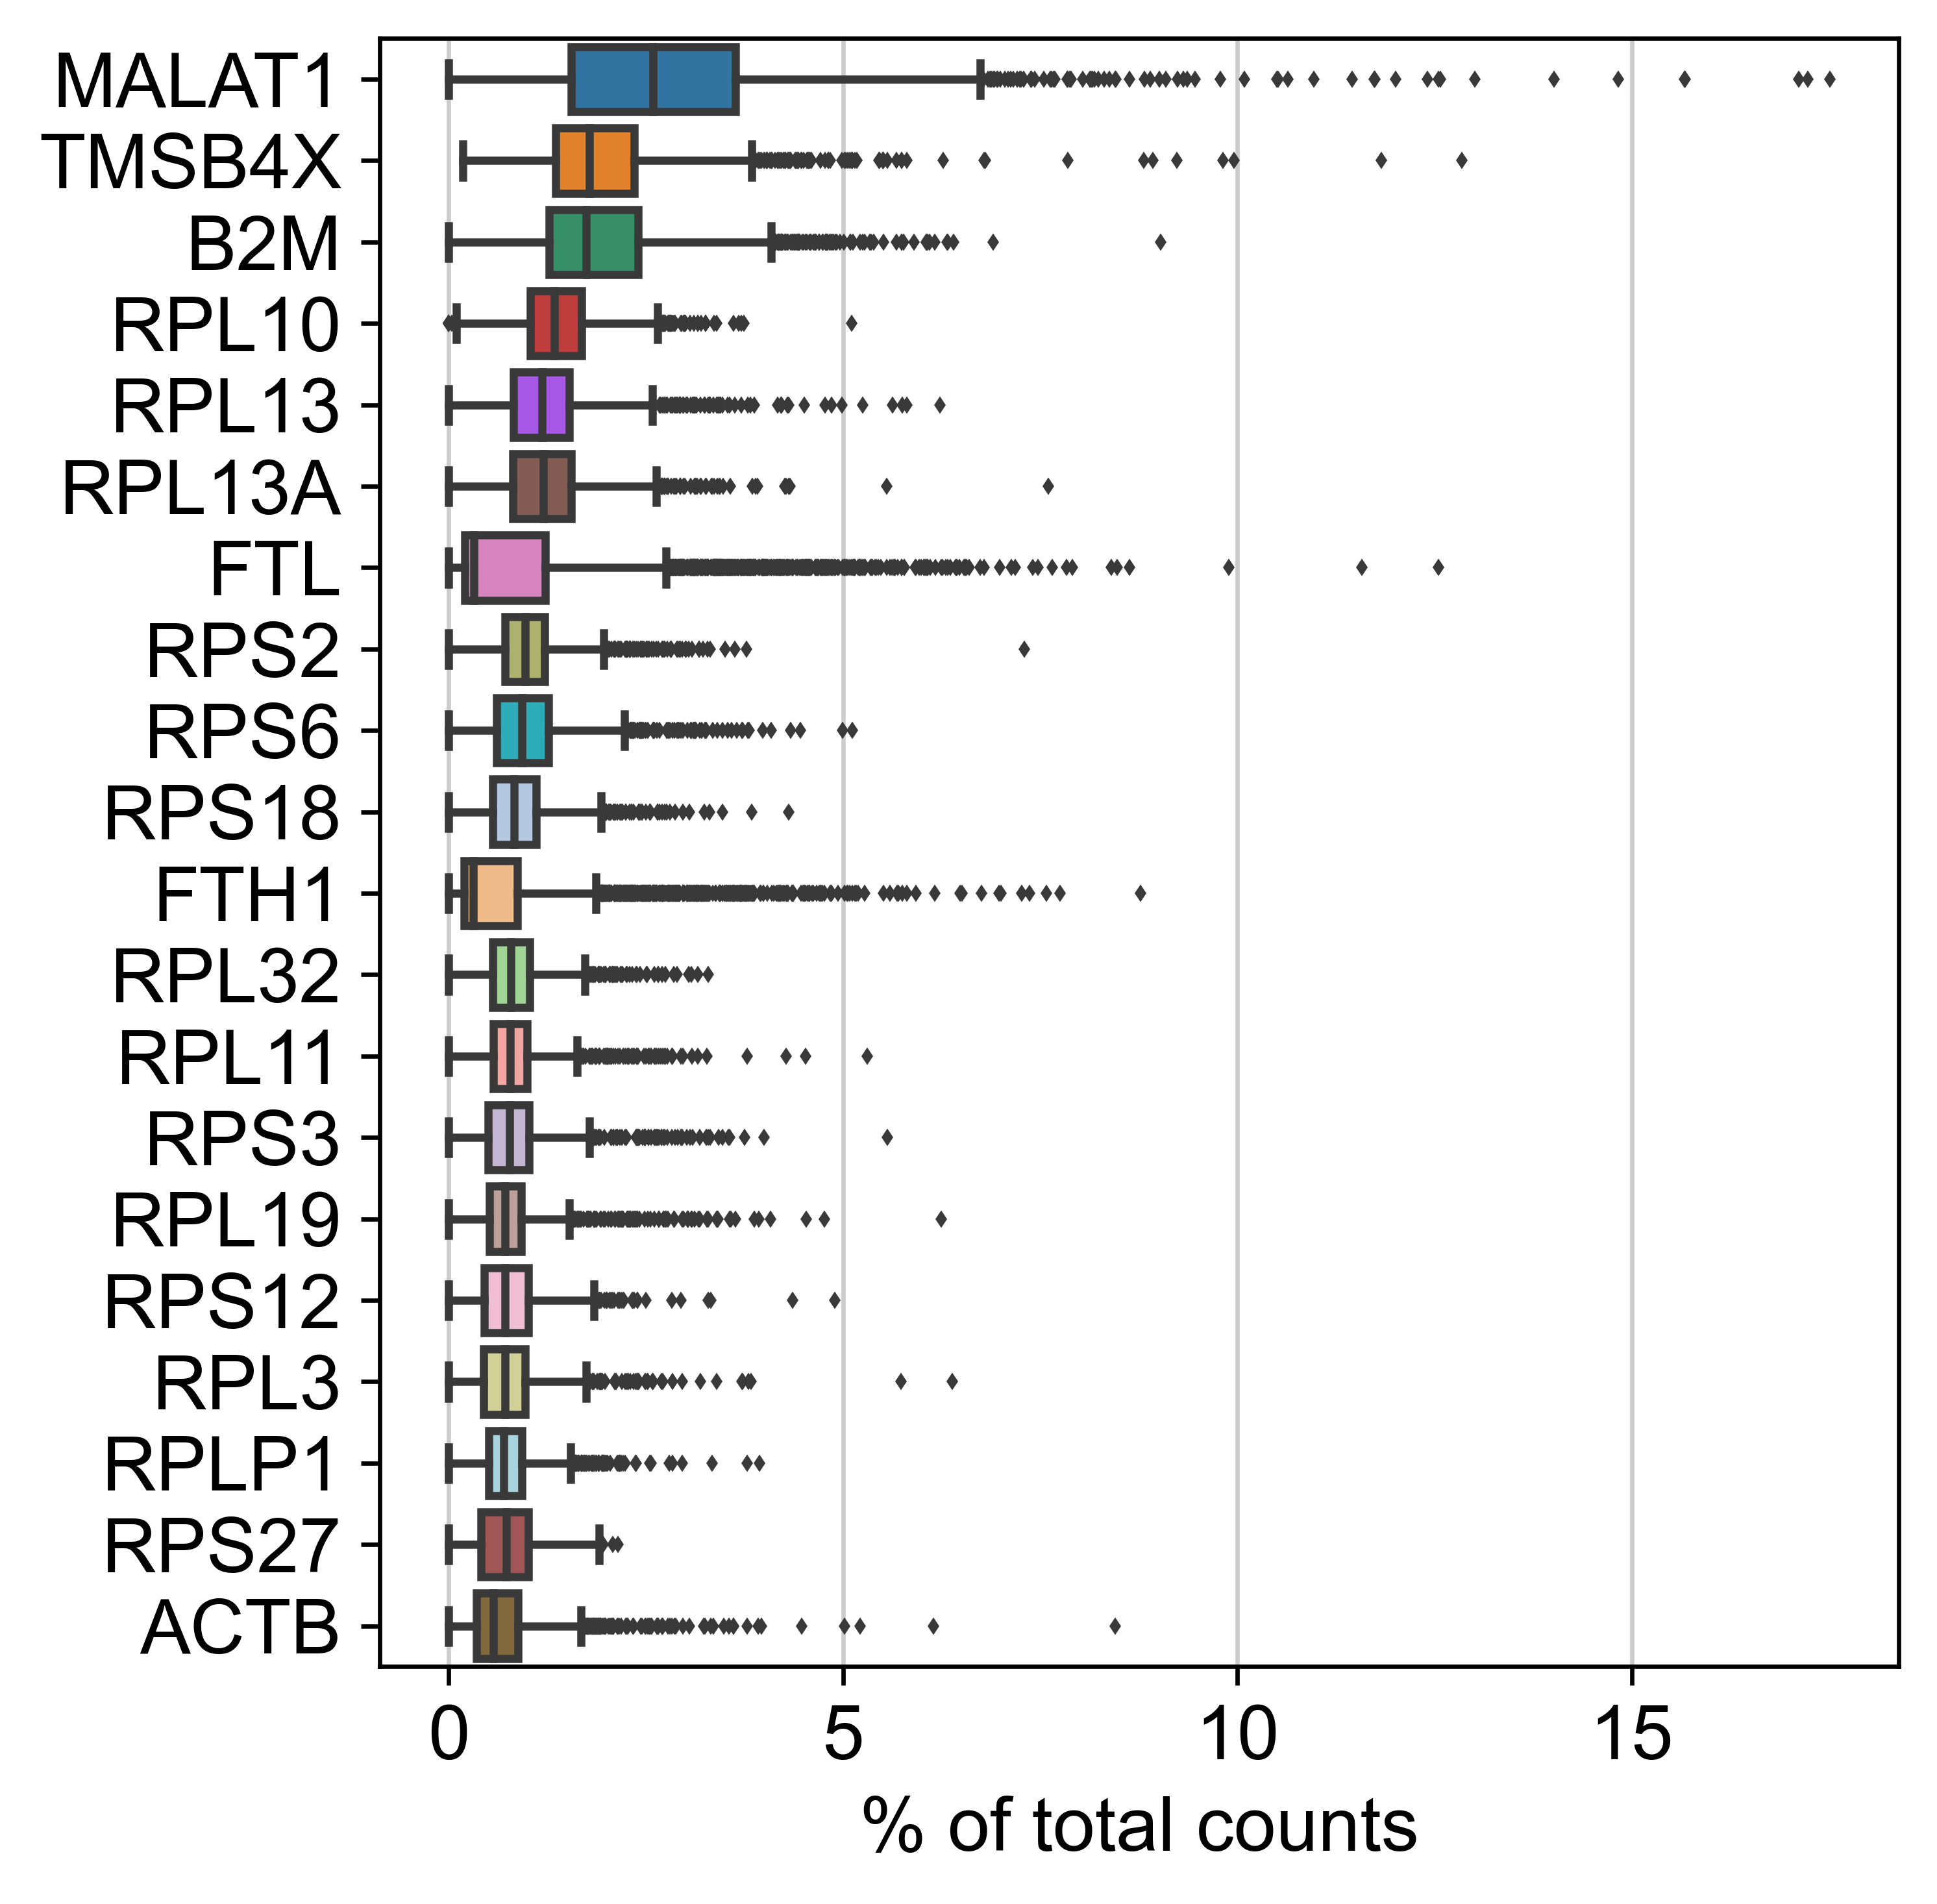

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )

### Filtering the cells

The two commands below remove cells that have fewer than 200 genes detected, and genes that are detected in fewer than 3 cells.

In [11]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


### Checking mitochondrial genes for QC

High proportions of mitochondrial genes indicate poor-quality cells, maybe because of loss of cytoplasmic RNA from perforated cells.

In [12]:
## the command line uses the fact that mitochondrial genes have gene symbols prefixed with 'MT-'
mito_genes = adata.var_names.str.startswith('MT-')
## for each cell, we compute the fraction of counts in mitochondrial genes versus all genes
## The `.A1` is only necessary since X is sparse. It transforms to a dense array after summing
adata.obs['percent_mito'] = np.sum(
    adata[:, mito_genes].X, axis=1).A1 / np.sum(adata.X, axis=1).A1
## add the total counts per cell as observations-annotation to adata
adata.obs["n_counts"] = adata.X.sum(axis=1).A1

We can use a *violin plot* to visulize computed quality measures. The 'n_genes' property was already there, and we have just added 'percent_mito' and 'n_counts' to the observation annotation. The ``sc.pl.violin`` function accepts adata and keys to make Violin plots.

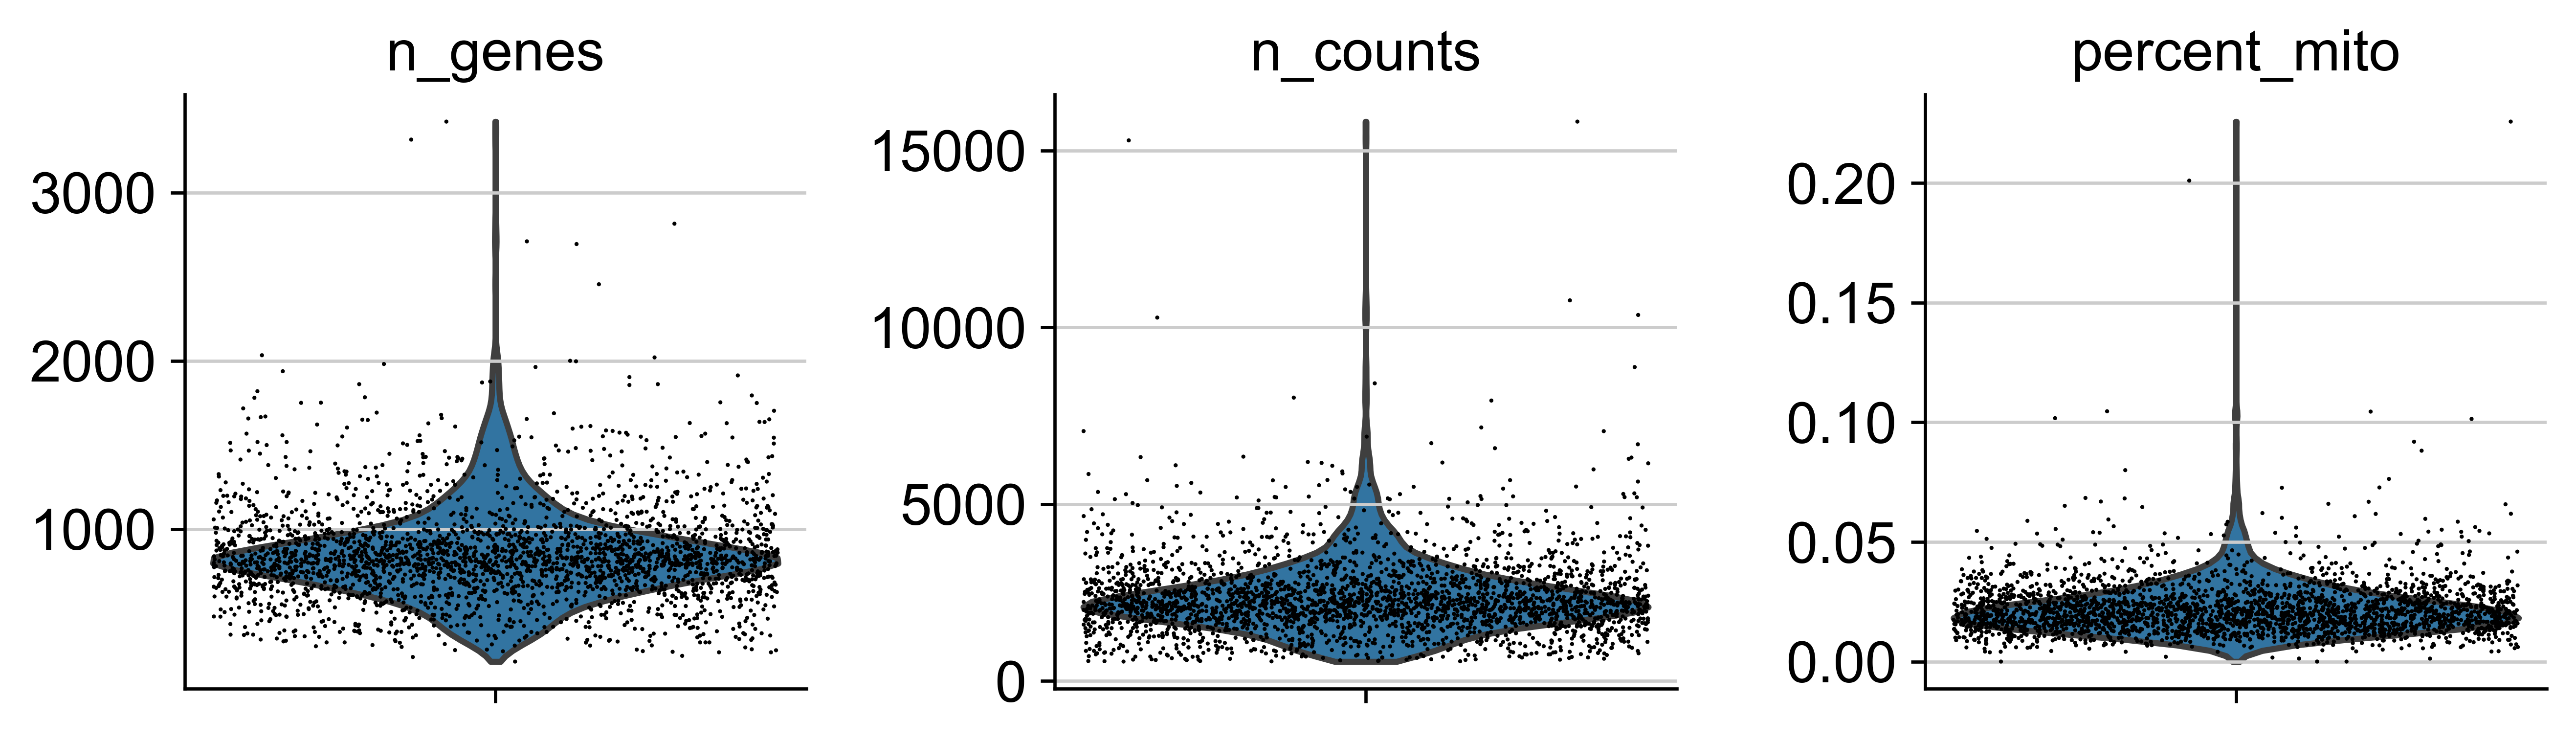

In [15]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'],
            jitter=0.4, multi_panel=True)

We also wish to remove cells that either have too many reads mapped to mitochondrial genes, which may indicate poor-quality cells, or have too many total counts, which may indicate cell aggregates. The following two plots help us identify the thresholds.

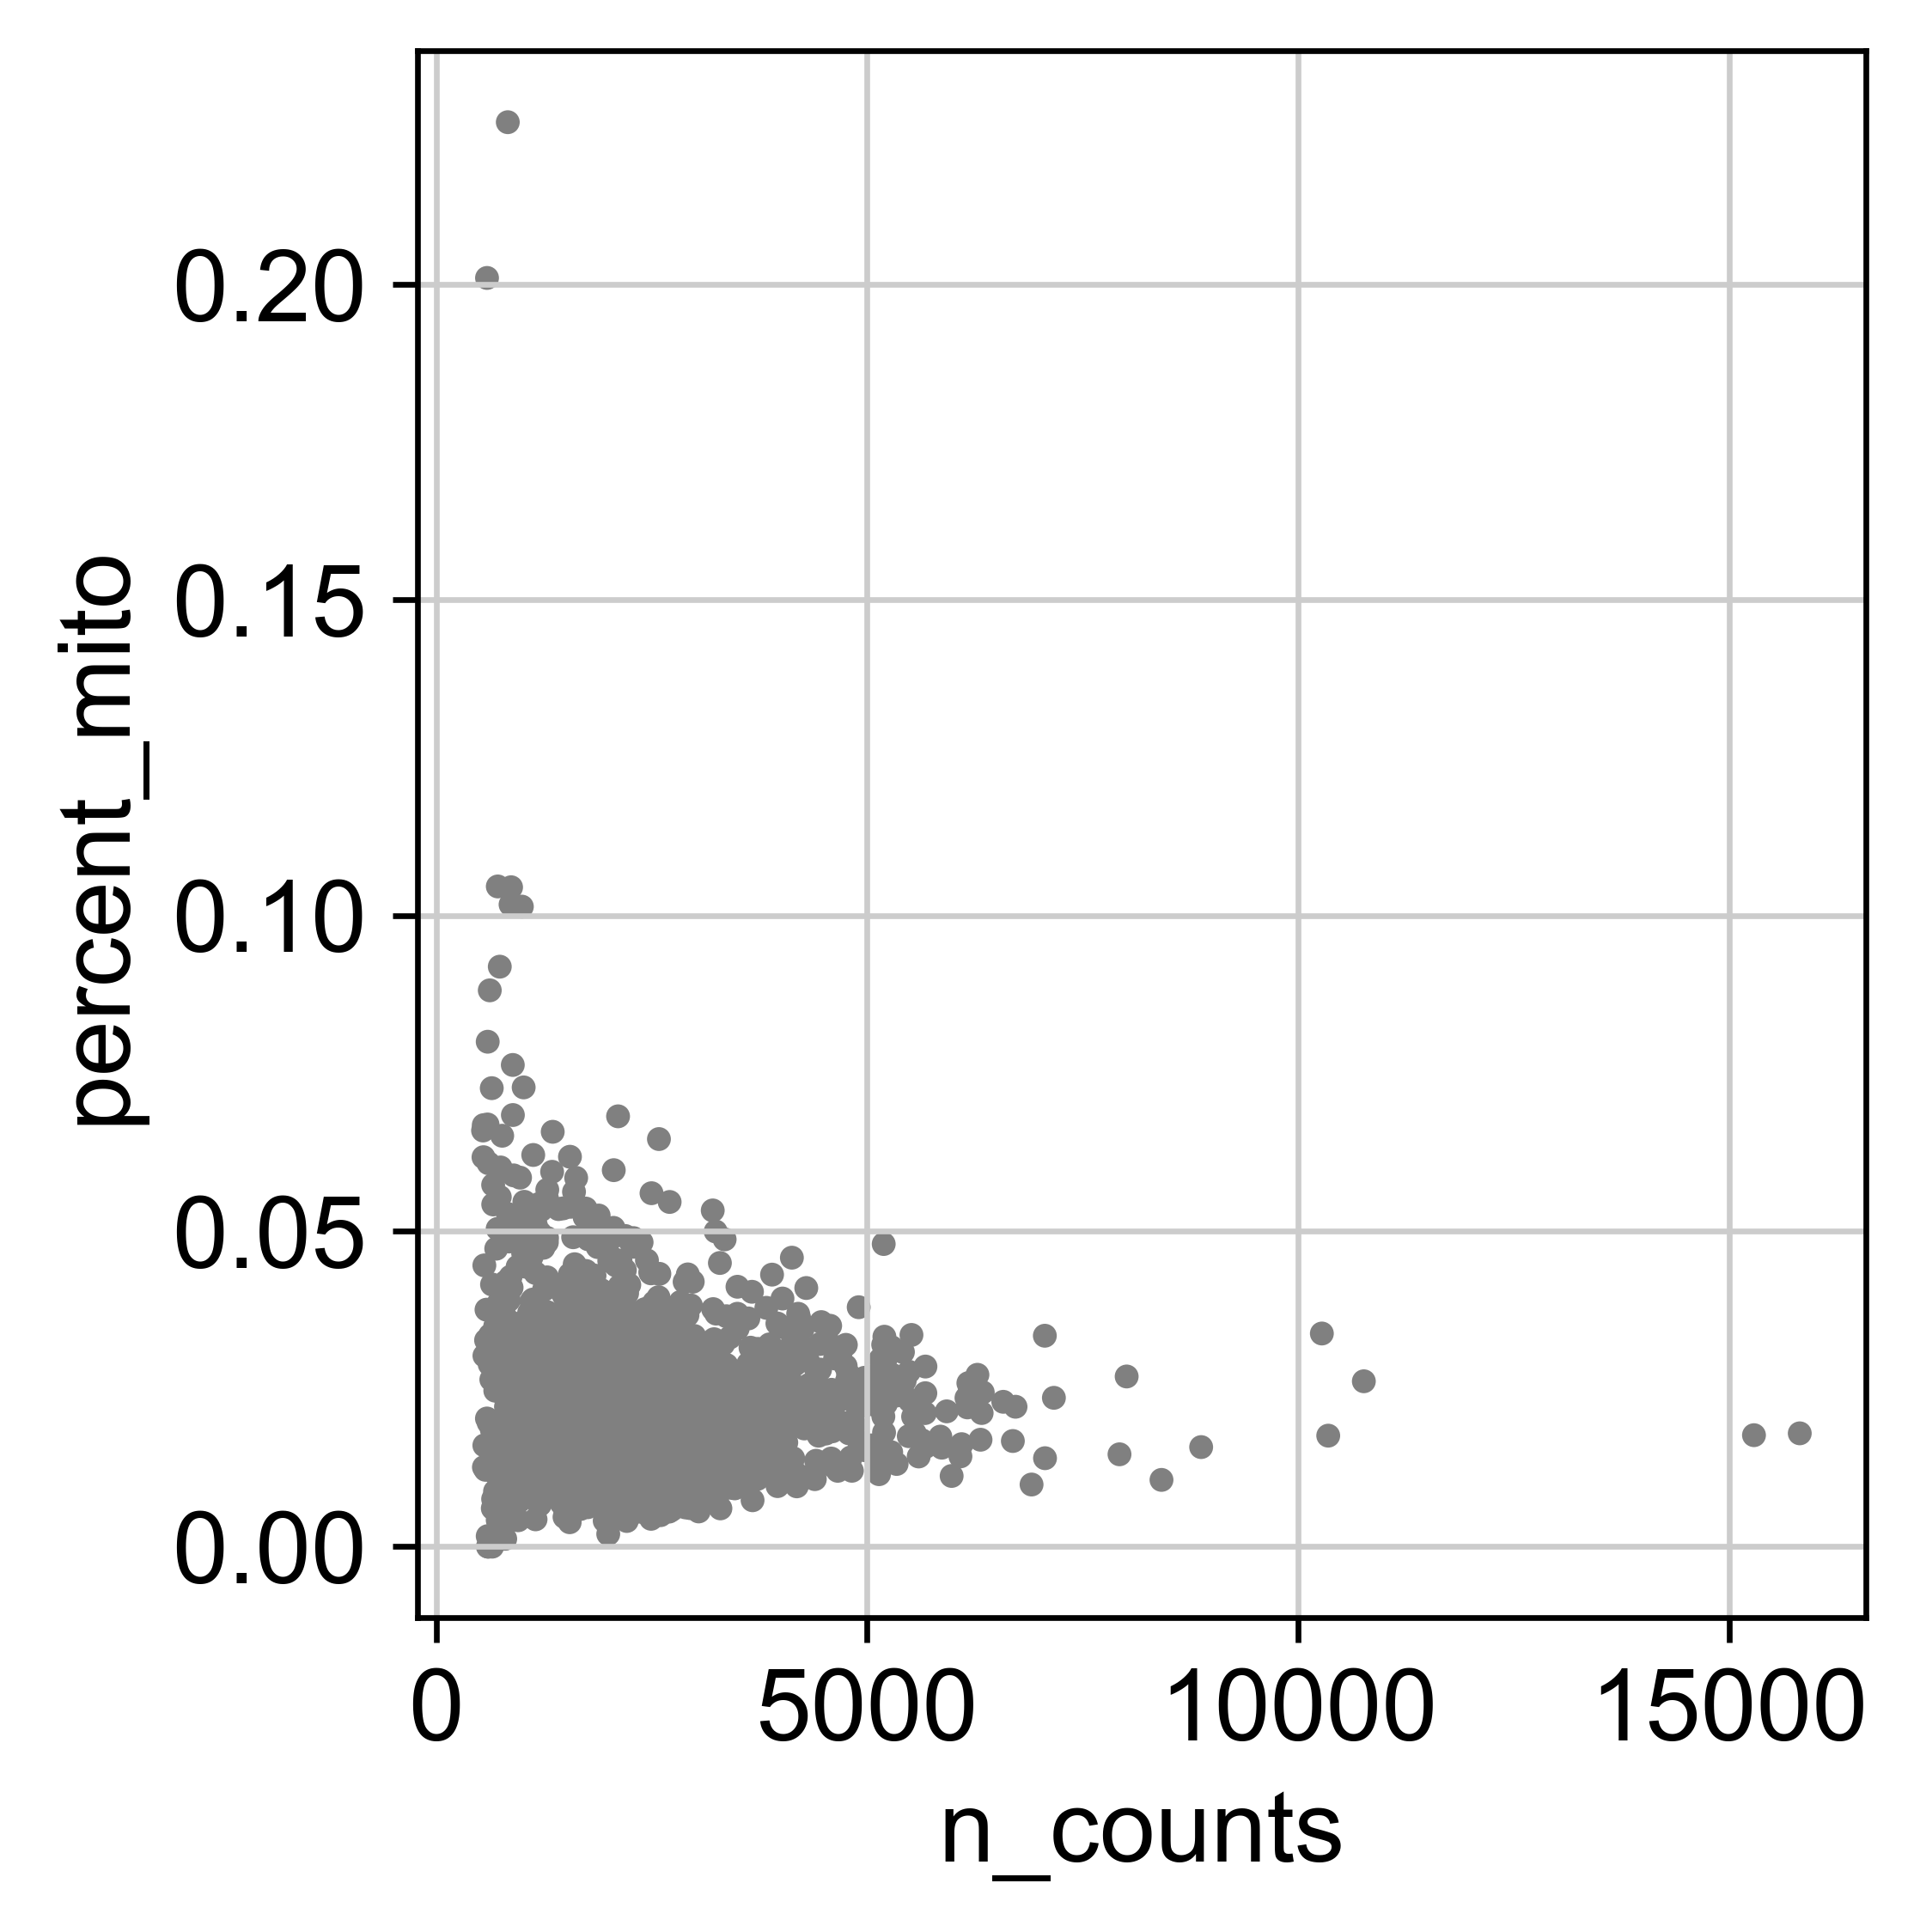

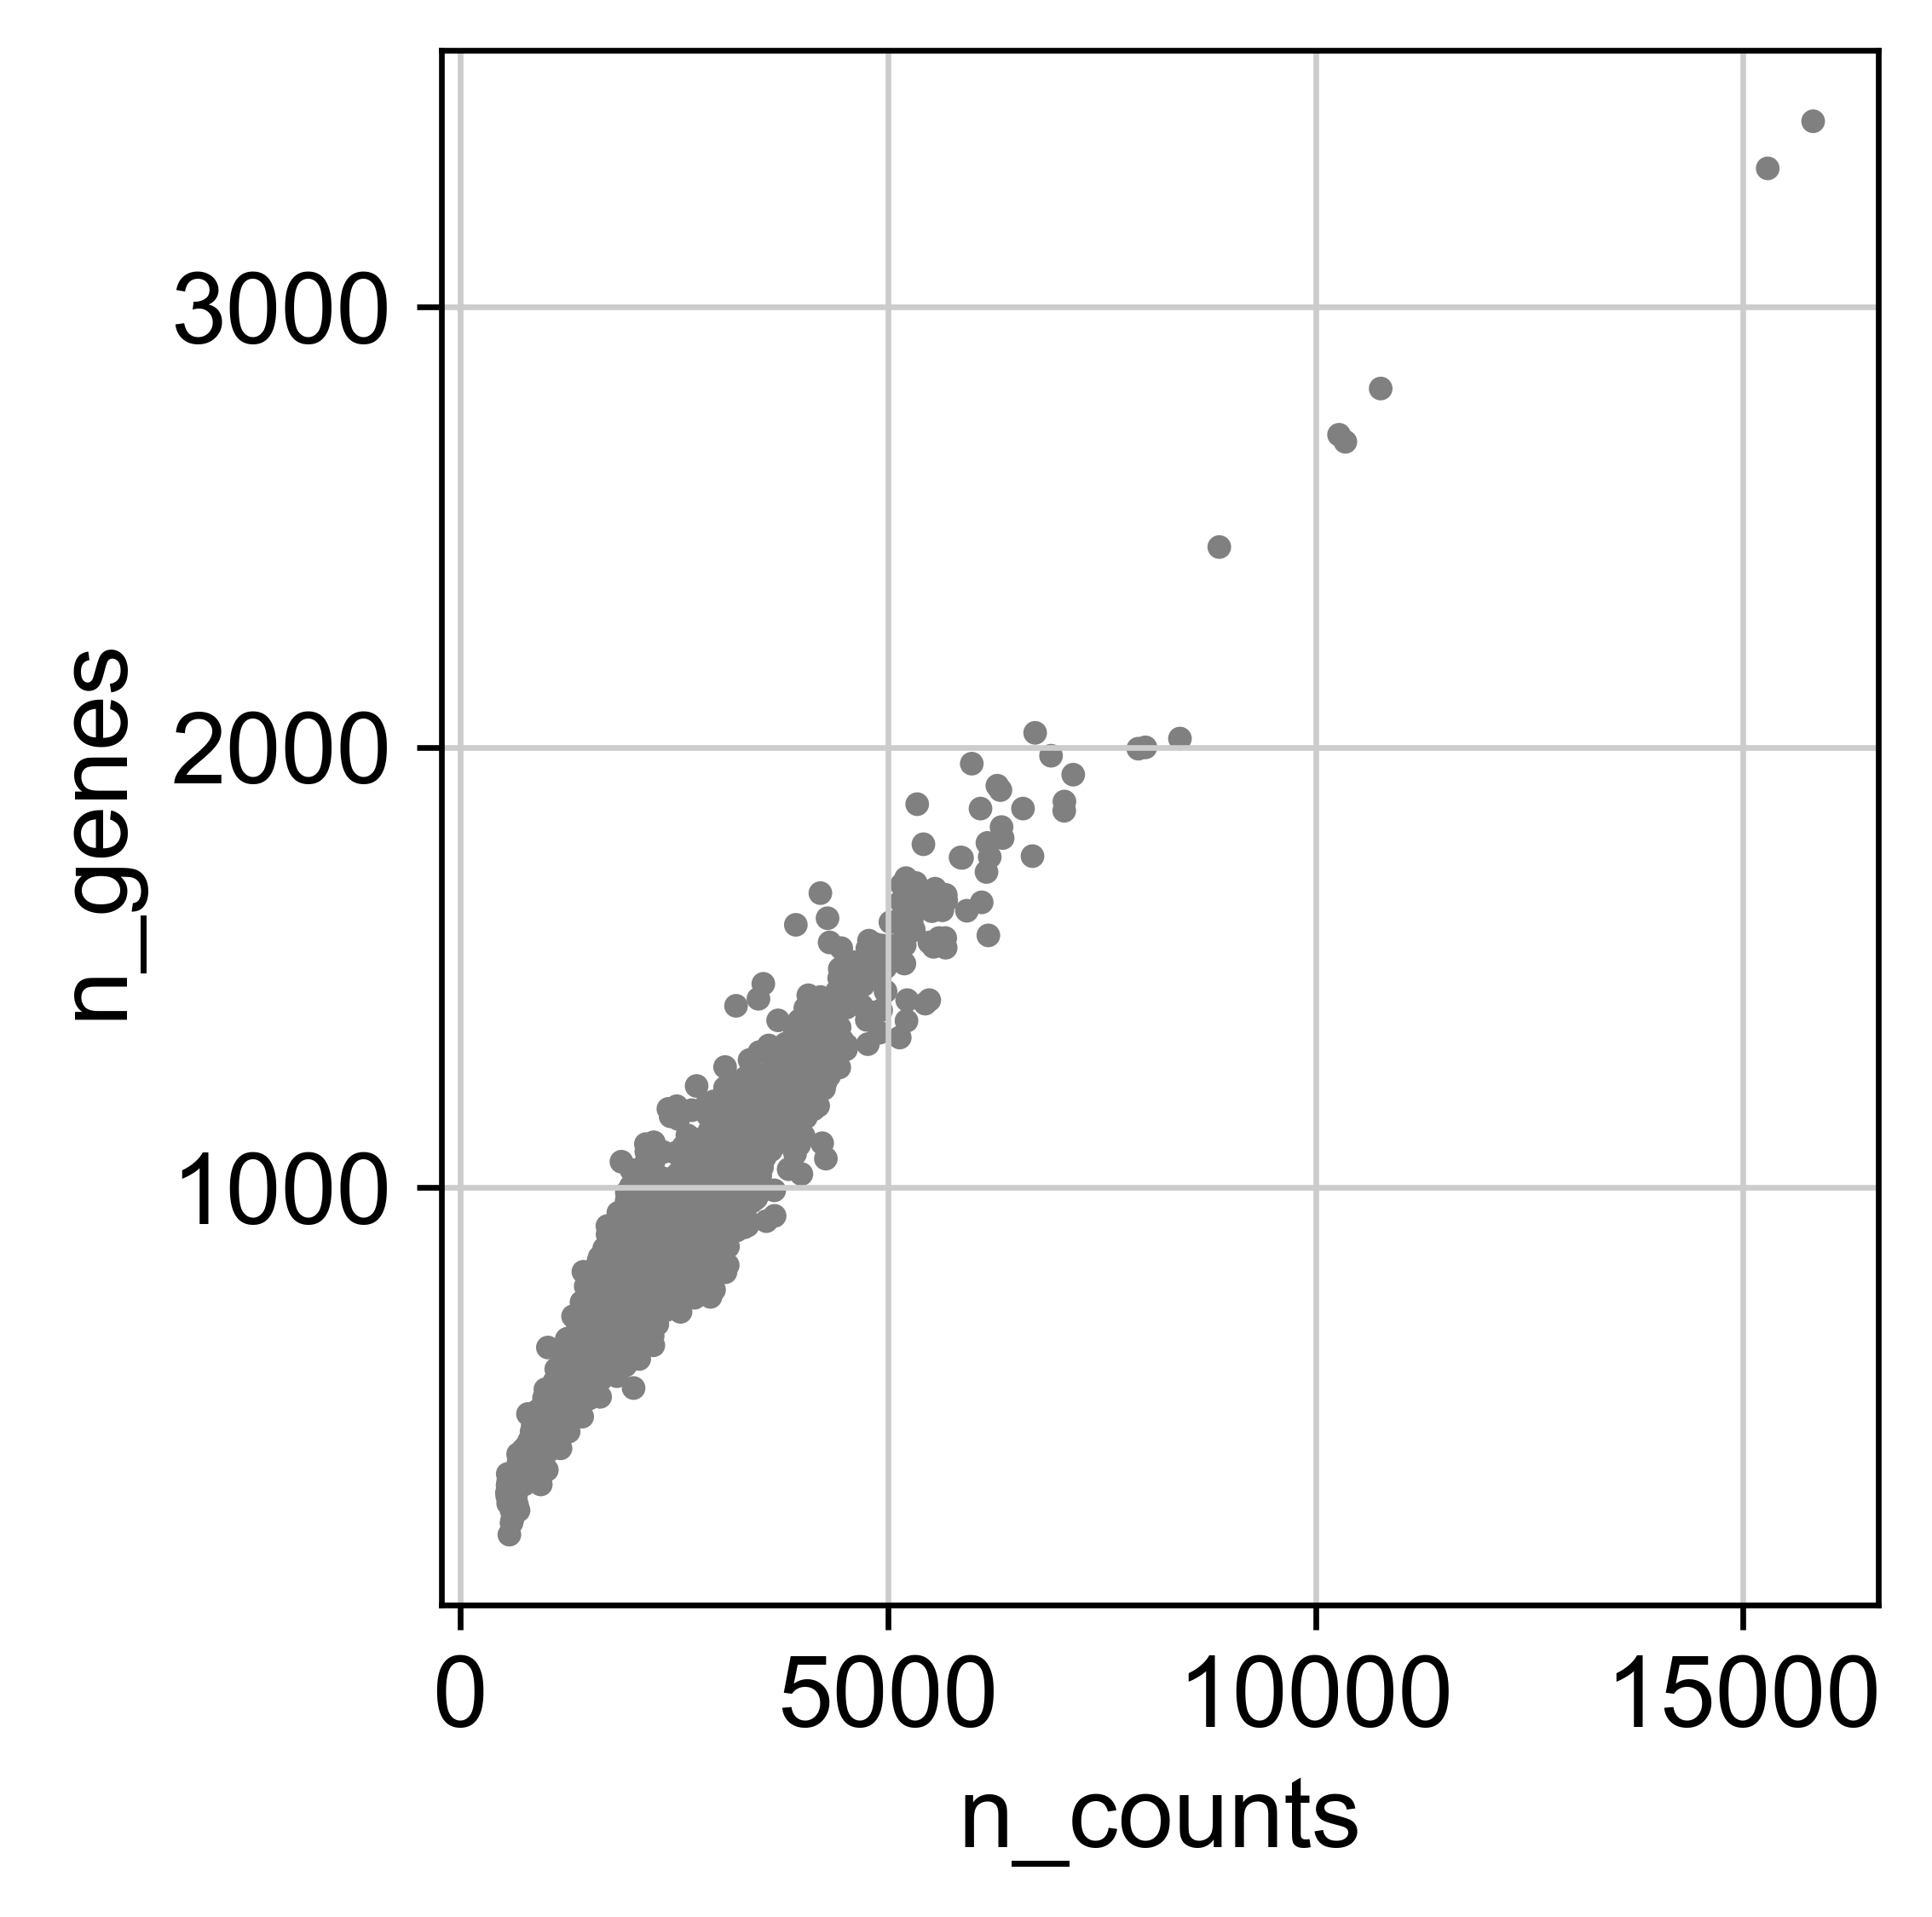

In [20]:
sc.pl.scatter(adata, x='n_counts', y='percent_mito')
sc.pl.scatter(adata, x='n_counts', y='n_genes')

### Filtering with metrics derived from QC

Now we are ready to do the actual filtering. Before the filtering, the dataset looks like this. There are 2,700 cells and 13,714 genes.

In [21]:
print(adata)

AnnData object with n_obs × n_vars = 2700 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


In [24]:
adata = adata[adata.obs.n_genes<2500, :]
adata = adata[adata.obs.percent_mito < 0.05, :]

In [26]:
print(adata)

View of AnnData object with n_obs × n_vars = 2638 × 13714 
    obs: 'n_genes', 'percent_mito', 'n_counts'
    var: 'gene_ids', 'n_cells'


### Data normlization

To correct differences in library sizes across cells, we normalize the total read count of the data matrix to 10,000 reads per cell so that counts become comparable among cells.

In [27]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:03)


We logarithmize the data for later use in differential gene expression as well as in visualizations. The natural logarithm is used, and ``log1p`` means that an extra read is added to cells of the count matrix as a pseudo-read.

In [ ]:
sc.pp.log1p(adata)

### Saving the data in the .raw attribute

This allows a later reuse of the raw data

In [30]:
adata.raw = adata

### Identifying highly-variable genes

The function `sc.pp.highly_variable_genes` can detect highly variable genes based on a few manually set parameters, including mininum mean expression, maximum mean expression, and minimum dispersion.

In [31]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes


/home/david/.local/lib/python3.6/site-packages/scipy/sparse/data.py:135: RuntimeWarning: overflow encountered in expm1
  result = op(self._deduped_data())


ValueError: cannot specify integer `bins` when input data contains infinity